# Modelling

### Libraries

In [2]:
# import libraries

import joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.special import inv_boxcox
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

### Data

In [3]:
# load negative, neutral and positive time series

negative_reviews_per_month = pd.read_csv('features/negative_reviews_per_month.csv', index_col=0, parse_dates=True)
neutral_reviews_per_month = pd.read_csv('features/neutral_reviews_per_month.csv', index_col=0, parse_dates=True)
positive_reviews_per_month = pd.read_csv('features/positive_reviews_per_month.csv', index_col=0, parse_dates=True)

In [4]:
# load sentiment time series

sentiment_per_month = pd.read_csv('features/sentiment_per_month.csv', index_col=0, parse_dates=True)

In [5]:
# load categories time series

sentiment_restaurants_per_month = pd.read_csv('features/sentiment_restaurants_per_month.csv', index_col=0, parse_dates=True)
sentiment_nightlife_per_month = pd.read_csv('features/sentiment_nightlife_per_month.csv', index_col=0, parse_dates=True)
sentiment_breakfast_brunch_per_month = pd.read_csv('features/sentiment_breakfast_brunch_per_month.csv', index_col=0, parse_dates=True)

### Models

In [6]:
# load ARIMA models

negative_box_cox_arimax = joblib.load('models/negative_box_cox_arimax.pkl')
negative_arimax = joblib.load('models/negative_arimax.pkl')
neutral_box_cox_arimax = joblib.load('models/neutral_box_cox_arimax.pkl')
neutral_arimax = joblib.load('models/neutral_arimax.pkl')
positive_box_cox_arimax = joblib.load('models/positive_box_cox_arimax.pkl')
positive_arimax = joblib.load('models/positive_arimax.pkl')

sentiment_box_cox_arima = joblib.load('models/sentiment_box_cox_arima.pkl')
sentiment_arima = joblib.load('models/sentiment_arima.pkl')

restaurant_box_cox_arima = joblib.load('models/restaurant_box_cox_arima.pkl')
restaurant_arima = joblib.load('models/restaurant_arima.pkl')
nightlife_box_cox_arima = joblib.load('models/nightlife_box_cox_arima.pkl')
nightlife_arima = joblib.load('models/nightlife_arima.pkl')
breakfast_brunch_box_cox_arima = joblib.load('models/breakfast_brunch_box_cox_arima.pkl')
breakfast_brunch_arima = joblib.load('models/breakfast_brunch_arima.pkl')

In [7]:
def baseline_model(data, method='mean'):
    '''
    Baseline model to predict the next value in a time series
    '''
    if method == 'mean':
        return data.mean()
    elif method == 'median':
        return data.median()
    elif method == 'naive':
        return data.iloc[-1]
    else:
        raise ValueError('Method not supported')

In [8]:
def ses_model(data):
    '''
    Simple Exponential Smoothing model
    '''
    model = SimpleExpSmoothing(data)
    fitted_model = model.fit()
    prediction = fitted_model.forecast(1)
    return prediction.iloc[0]

In [9]:
def holt_linear_damped_model(data):
    '''
    Holt Linear Trend model with damping
    '''
    model = ExponentialSmoothing(data, trend='add', damped_trend=True)
    fitted_model = model.fit()
    prediction = fitted_model.forecast(1)
    return prediction.iloc[0]

In [10]:
models = {
    'baseline_mean': lambda x: baseline_model(x, method='mean'),
    'baseline_median': lambda x: baseline_model(x, method='median'),
    'baseline_naive': lambda x: baseline_model(x, method='naive'),
    'ses': lambda x: ses_model(x),
    'holt_linear_damped': lambda x: holt_linear_damped_model(x)
}

variables = []

### Predictions

In [11]:
# shift and lambda values (from mathematical transformations)

shift_negative = 1
shift_neutral = 1
shift_positive = 1
shift_sentiment = 0
shift_restaurants = 2
shift_nightlife = 2
shift_breakfast_brunch = 2

lambda_negative = 0
lambda_neutral = 0
lambda_positive = 0
lambda_sentiment = 1.5
lambda_restaurants = 1.5
lambda_nightlife = 1.5
lambda_breakfast_brunch = 1.5

In [12]:
def revert_forecast(forecast, lambda_, shift):
    """
    Reverts the forecasted values to the original scale (reverts box-cox, then shift)
    """
    forecast = inv_boxcox(forecast, lambda_)
    forecast = forecast - shift
    return forecast

In [13]:
def cross_validation_predictions(data, model, min_train_size=12):
    '''
    Function to perform cross-validation and obtain predictions
    '''
    results = []
    for i in range(min_train_size, len(data)):
        train = data.iloc[:i]
        test = data.iloc[i:i+1]
        prediction = model(train)
        if not test.empty:
            result_entry = {'date': test.index[0], 'actual': test.iloc[0], 'prediction': prediction}
            results.append(result_entry)
    return pd.DataFrame(results)

### Evaluation

In [14]:
def mean_absolute_percentage_error(y_true, y_pred):
    '''
    Mean Absolute Percentage Error (MAPE) metric
    '''
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [15]:
def mean_absolute_scaled_error(y_true, y_pred, y_train):
    '''
    Mean Absolute Scaled Error (MASE) metric
    '''
    y_true, y_pred, y_train = np.array(y_true), np.array(y_pred), np.array(y_train)
    naive_forecast = y_train[1:] - y_train[:-1]
    mae_naive = np.mean(np.abs(naive_forecast))
    mae_forecast = np.mean(np.abs(y_true - y_pred))
    mase = mae_forecast / mae_naive
    return mase

In [16]:
def evaluate(y_true, y_pred):
    '''
    Evaluate the model using different metrics
    '''
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return mae, mse, rmse, mape

In [17]:
def evaluate_and_plot_best(data, used_lambda=None, used_shift=None, comparison='MSE', extra_models={}, extra_variables=[]):
    '''
    Evaluate the best model and plot the results
    '''
    best_model = None
    best_comparison = float('inf')
    best_results = None
    results = pd.DataFrame(columns=['Model', 'MAE', 'MSE', 'RMSE', 'MAPE', 'MASE'])
    to_be_used_models = list(models.items()) + list(extra_models.items())
    to_be_used_models = dict(to_be_used_models)
    
    for model_name, model in to_be_used_models.items():
        for variable in variables + extra_variables:
            exam_data = data.copy()[variable]
            exam_data = exam_data.dropna()
            predictions = cross_validation_predictions(exam_data, model)
            if model_name == 'box_cox_arima':
                predictions['prediction'] = revert_forecast(predictions['prediction'], used_lambda, used_shift)
                predictions['actual'] = revert_forecast(predictions['actual'], used_lambda, used_shift)
            predictions = predictions.dropna().reset_index(drop=True)
            
            mae, mse, rmse, mape = evaluate(predictions['actual'], predictions['prediction'])
            mase = mean_absolute_scaled_error(predictions['actual'], predictions['prediction'], exam_data)
            results = pd.concat([results, pd.DataFrame({
                'Model': model_name + '_' + variable, 
                'MAE': mae, 
                'MSE': mse, 
                'RMSE': rmse, 
                'MAPE': mape, 
                'MASE': mase
            }, index=[0])], ignore_index=True)
            
            if results.iloc[-1][comparison] < best_comparison:
                best_comparison = results.iloc[-1][comparison]
                best_model = model_name + '_' + variable
                best_results = predictions
    
    print('Best model:', best_model)
    print(comparison + ':', best_comparison)
    best_results.plot(x='date', y=['actual', 'prediction'], title=best_model)
    
    return results

In [18]:
# create exogenous variables (COVID)
def covid_event(date):
    '''
    Check if date is within COVID-19 event period
    '''
    start_date = pd.to_datetime('2020-01-31')
    end_date = pd.to_datetime('2020-07-31')
    return start_date <= date <= end_date

negative_exog_variables = pd.DataFrame(index=negative_reviews_per_month['box_cox'].index)
neutral_exog_variables = pd.DataFrame(index=neutral_reviews_per_month['box_cox'].index)
positive_exog_variables = pd.DataFrame(index=positive_reviews_per_month['box_cox'].index)

negative_exog_variables['covid'] = 0
neutral_exog_variables['covid'] = 0
positive_exog_variables['covid'] = 0

for date in negative_exog_variables.index:
    if covid_event(date):
        negative_exog_variables.loc[date, 'covid'] = 1

for date in neutral_exog_variables.index:
    if covid_event(date):
        neutral_exog_variables.loc[date, 'covid'] = 1
        
for date in positive_exog_variables.index:
    if covid_event(date):
        positive_exog_variables.loc[date, 'covid'] = 1

#### Negative reviews

In [19]:
# box-cox model info

print(negative_box_cox_arimax.summary())

                               SARIMAX Results                                
Dep. Variable:                box_cox   No. Observations:                  186
Model:                 ARIMA(2, 2, 2)   Log Likelihood                 -56.866
Date:                Mon, 20 May 2024   AIC                            125.731
Time:                        17:42:10   BIC                            145.021
Sample:                    08-31-2006   HQIC                           133.550
                         - 01-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
covid         -0.1984      0.200     -0.992      0.321      -0.590       0.194
ar.L1          0.3417      0.063      5.428      0.000       0.218       0.465
ar.L2          0.2320      0.075      3.111      0.0

In [20]:
# model info

print(negative_arimax.summary())

                               SARIMAX Results                                
Dep. Variable:                  count   No. Observations:                  186
Model:                 ARIMA(1, 2, 4)   Log Likelihood                -805.518
Date:                Mon, 20 May 2024   AIC                           1625.036
Time:                        17:42:19   BIC                           1647.540
Sample:                    08-31-2006   HQIC                          1634.157
                         - 01-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
covid         21.5439     23.115      0.932      0.351     -23.762      66.849
ar.L1          0.8055      0.135      5.949      0.000       0.540       1.071
ma.L1         -1.8900      0.137    -13.791      0.0

C:\Users\Utilizador\AppData\Local\Temp\ipykernel_14340\3372731274.py:6: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_14340\4044320444.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_14340\3372731274.py:6: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_14340\3372731274.py:6: RuntimeWarning: invalid value encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
C:\Users\Utilizador\AppData\Local\T

Best model: baseline_naive_count
MSE: 409.235632183908


c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_14340\3372731274.py:6: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


Model            MAE            MSE           RMSE  \
0       baseline_mean_count   5.586479e+01   5.963310e+03   7.722247e+01   
1     baseline_median_count   6.684770e+01   8.352139e+03   9.139004e+01   
2      baseline_naive_count   1.376437e+01   4.092356e+02   2.022957e+01   
3                 ses_count   1.332900e+01   4.201722e+02   2.049810e+01   
4  holt_linear_damped_count   1.349519e+01   4.328445e+02   2.080492e+01   
5       box_cox_arima_count  1.864473e+123  6.048690e+248  2.459408e+124   
6               arima_count   1.562401e+01   1.028043e+03   3.206311e+01   

   MAPE           MASE  
0   inf   4.302659e+00  
1   NaN   5.148553e+00  
2   inf   1.060120e+00  
3   inf   1.026589e+00  
4   inf   1.039388e+00  
5   inf  1.436001e+122  
6   inf   1.203348e+00

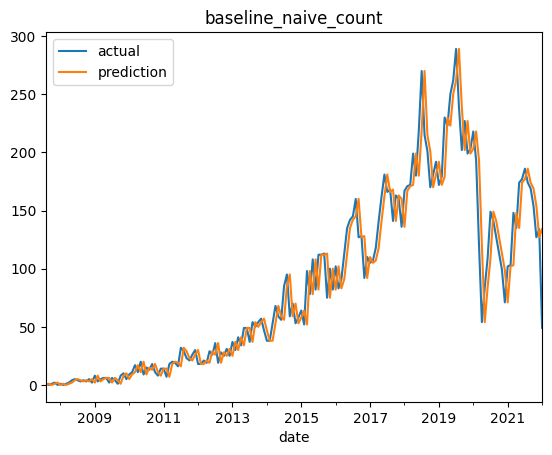

In [21]:
def box_cox_temp(x):
    time_series_for_arimax = negative_reviews_per_month['box_cox'].reindex(x.index)
    train_exog = negative_exog_variables.reindex(time_series_for_arimax.index)
    train_exog = train_exog.fillna(method='ffill')
    test_exog = negative_exog_variables.reindex(x.index[-1:])
    test_exog = test_exog.fillna(method='ffill')
    return ARIMA(time_series_for_arimax, order=(2, 2, 2), exog=train_exog.iloc[:len(x)]).fit().forecast(1, exog=test_exog).iloc[0]

def temp(x):
    time_series_for_arimax = negative_reviews_per_month['count'].reindex(x.index)
    train_exog = negative_exog_variables.reindex(time_series_for_arimax.index)
    train_exog = train_exog.fillna(method='ffill')
    test_exog = negative_exog_variables.reindex(x.index[-1:])
    test_exog = test_exog.fillna(method='ffill')
    return ARIMA(time_series_for_arimax, order=(1, 2, 4), exog=train_exog.iloc[:len(x)]).fit().forecast(1, exog=test_exog).iloc[0]

evaluate_and_plot_best(
    negative_reviews_per_month, 
    lambda_negative, 
    shift_negative,  
    comparison='MSE', 
    extra_models={'box_cox_arima': box_cox_temp, 'arima': temp}, 
    extra_variables=['count']
)

In [ ]:
# Plot future forecast for the best model with probability intervals

# Model ARIMAX
variable = 'count'

exam_data = negative_reviews_per_month.copy()[variable]
exam_data = exam_data.dropna()
train = exam_data

train_exog = negative_exog_variables.reindex(train.index)
train_exog = train_exog.fillna(method='ffill')

# predictions for the next 12 months
model = ARIMA(train, order=(1,1,1), exog=train_exog)
results = model.fit()
fig, ax = plt.subplots()
ax = train.plot(ax=ax)
plot_predict(results, '2020', '2023', exog=[0]*18, ax=ax)
plt.show()

#### Neutral reviews

In [22]:
# box-cox model info

print(neutral_box_cox_arimax.summary())

                               SARIMAX Results                                
Dep. Variable:                box_cox   No. Observations:                  198
Model:                 ARIMA(1, 1, 2)   Log Likelihood                 -67.804
Date:                Mon, 20 May 2024   AIC                            145.608
Time:                        17:47:20   BIC                            162.025
Sample:                    08-31-2005   HQIC                           152.254
                         - 01-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
covid         -0.1808      0.172     -1.050      0.294      -0.518       0.157
ar.L1         -0.5950      0.207     -2.868      0.004      -1.002      -0.188
ma.L1          0.1302      0.180      0.725      0.4

In [23]:
# model info

print(neutral_arimax.summary())

                               SARIMAX Results                                
Dep. Variable:                  count   No. Observations:                  198
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -706.960
Date:                Mon, 20 May 2024   AIC                           1429.919
Time:                        17:47:22   BIC                           1456.185
Sample:                    08-31-2005   HQIC                          1440.552
                         - 01-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
covid          9.8271      6.321      1.555      0.120      -2.562      22.217
ar.L1          0.6089      0.078      7.768      0.000       0.455       0.763
ar.L2         -0.7457      0.051    -14.596      0.0

C:\Users\Utilizador\AppData\Local\Temp\ipykernel_14340\3372731274.py:6: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_14340\4044320444.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_14340\3372731274.py:6: RuntimeWarning: invalid value encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_14340\3372731274.py:6: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
C:\Users\Utilizador\AppData\Local\T

Best model: ses_count
MSE: 90.64789072797753


c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_14340\3372731274.py:6: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


Model           MAE           MSE          RMSE  MAPE  \
0       baseline_mean_count  2.040263e+01  7.898865e+02  2.810492e+01   inf   
1     baseline_median_count  2.325269e+01  9.765833e+02  3.125033e+01   NaN   
2      baseline_naive_count  7.069892e+00  9.603763e+01  9.799879e+00   NaN   
3                 ses_count  6.551624e+00  9.064789e+01  9.520919e+00   inf   
4  holt_linear_damped_count  6.584294e+00  9.163199e+01  9.572460e+00   inf   
5       box_cox_arima_count  1.171470e+45  2.550846e+92  1.597137e+46   NaN   
6               arima_count  6.802044e+00  9.578492e+01  9.786977e+00   inf   

           MASE  
0  3.054194e+00  
1  3.480836e+00  
2  1.058335e+00  
3  9.807522e-01  
4  9.856427e-01  
5  1.753645e+44  
6  1.018239e+00

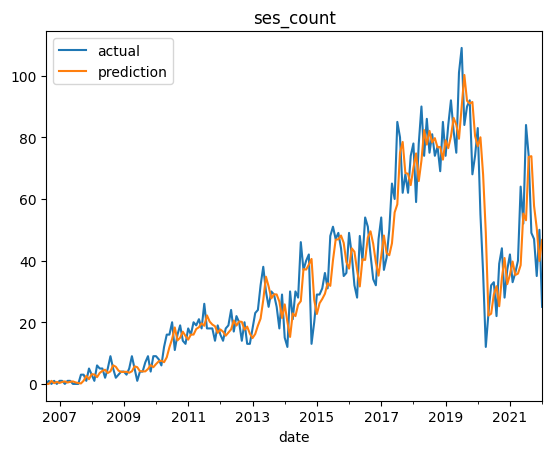

In [24]:
def box_cox_temp(x):
    time_series_for_arimax = neutral_reviews_per_month['box_cox'].reindex(x.index)
    train_exog = neutral_exog_variables.reindex(time_series_for_arimax.index)
    train_exog = train_exog.fillna(method='ffill')
    test_exog = neutral_exog_variables.reindex(x.index[-1:])
    test_exog = test_exog.fillna(method='ffill')
    return ARIMA(time_series_for_arimax, order=(1, 1, 2), exog=train_exog.iloc[:len(x)]).fit().forecast(1, exog=test_exog).iloc[0]

def temp(x):
    time_series_for_arimax = neutral_reviews_per_month['count'].reindex(x.index)
    train_exog = neutral_exog_variables.reindex(time_series_for_arimax.index)
    train_exog = train_exog.fillna(method='ffill')
    test_exog = neutral_exog_variables.reindex(x.index[-1:])
    test_exog = test_exog.fillna(method='ffill')
    return ARIMA(time_series_for_arimax, order=(3, 1, 3), exog=train_exog.iloc[:len(x)]).fit().forecast(1, exog=test_exog).iloc[0]

evaluate_and_plot_best(
    neutral_reviews_per_month, 
    lambda_neutral, 
    shift_neutral,  
    comparison='MSE', 
    extra_models={'box_cox_arima': box_cox_temp, 'arima': temp}, 
    extra_variables=['count']
)

c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_14340\206129884.py:27: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=train.index[-1], periods=forecast_periods+1, freq='M')[1:]


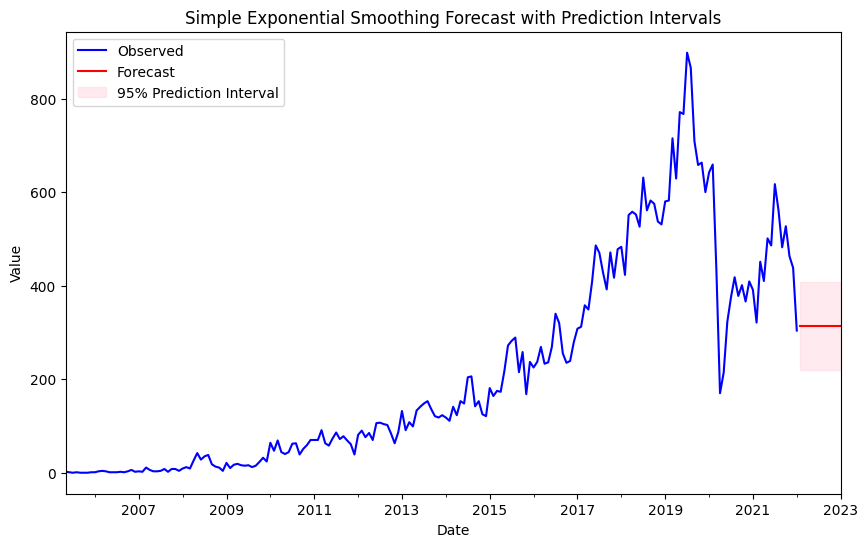

In [50]:
# Plot future forecast for the best model with probability intervals

# Model Holt Linear Damped
variable = 'count'

exam_data = positive_reviews_per_month.copy()[variable]
exam_data = exam_data.dropna()
train = exam_data

# Fit the SimpleExponentialSmoothing model
model = SimpleExpSmoothing(train)
results = model.fit()

# Generate forecasts for the next 12 months
forecast_periods = 12
forecast = results.forecast(forecast_periods)

# Calculate prediction intervals
alpha = 0.05
z = 1.96  # Z-score for 95% confidence interval

# Calculate standard error of forecast
residuals = train - results.fittedvalues
stderr = residuals.std()

# Generate confidence intervals
forecast_index = pd.date_range(start=train.index[-1], periods=forecast_periods+1, freq='M')[1:]
conf_int = z * stderr

# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))
train.plot(ax=ax, label='Observed', color='blue')
forecast.plot(ax=ax, label='Forecast', color='red')

# Plot confidence intervals
ax.fill_between(forecast_index, forecast - conf_int, forecast + conf_int, color='pink', alpha=0.3, label='95% Prediction Interval')

# Add labels and legend
ax.set_title('Simple Exponential Smoothing Forecast with Prediction Intervals')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.legend(loc='upper left')

# Show the plot
plt.show()

#### Positive reviews

In [25]:
# box-cox model info

print(positive_box_cox_arimax.summary())

                               SARIMAX Results                                
Dep. Variable:                box_cox   No. Observations:                  201
Model:                 ARIMA(3, 2, 4)   Log Likelihood                 -55.739
Date:                Mon, 20 May 2024   AIC                            129.478
Time:                        17:50:12   BIC                            159.117
Sample:                    05-31-2005   HQIC                           141.473
                         - 01-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
covid         -0.1544      0.366     -0.422      0.673      -0.871       0.562
ar.L1         -1.1550      0.121     -9.531      0.000      -1.393      -0.917
ar.L2         -0.1284      0.202     -0.637      0.5

In [26]:
# model info

print(positive_arimax.summary())

                               SARIMAX Results                                
Dep. Variable:                  count   No. Observations:                  201
Model:                 ARIMA(2, 2, 3)   Log Likelihood               -1044.106
Date:                Mon, 20 May 2024   AIC                           2102.212
Time:                        17:50:15   BIC                           2125.265
Sample:                    05-31-2005   HQIC                          2111.542
                         - 01-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
covid         37.5707     18.670      2.012      0.044       0.979      74.163
ar.L1         -1.5106      0.030    -51.021      0.000      -1.569      -1.453
ar.L2         -0.8250      0.034    -23.982      0.0

In [42]:
def box_cox_temp(x):
    time_series_for_arimax = positive_reviews_per_month['box_cox'].reindex(x.index)
    train_exog = positive_exog_variables.reindex(time_series_for_arimax.index)
    train_exog = train_exog.fillna(method='ffill')
    test_exog = positive_exog_variables.reindex(x.index[-1:])
    test_exog = test_exog.fillna(method='ffill')
    return ARIMA(time_series_for_arimax, order=(3, 2, 4), exog=train_exog.iloc[:len(x)]).fit().forecast(1, exog=test_exog).iloc[0]

def temp(x):
    time_series_for_arimax = positive_reviews_per_month['count'].reindex(x.index)
    train_exog = positive_exog_variables.reindex(time_series_for_arimax.index)
    train_exog = train_exog.fillna(method='ffill')
    test_exog = positive_exog_variables.reindex(x.index[-1:])
    test_exog = test_exog.fillna(method='ffill')
    return ARIMA(time_series_for_arimax, order=(2, 2, 3), exog=train_exog.iloc[:len(x)]).fit().forecast(1, exog=test_exog).iloc[0]

evaluate_and_plot_best(
    positive_reviews_per_month, 
    lambda_positive, 
    shift_positive,  
    comparison='MSE', 
    extra_models={'box_cox_arima': box_cox_temp, 'arima': temp},
    extra_variables=['count']
)

C:\Users\Utilizador\AppData\Local\Temp\ipykernel_14340\4044320444.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_m

LinAlgError: LU decomposition error.

c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_14340\1301324503.py:27: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=train.index[-1], periods=forecast_periods+1, freq='M')[1:]


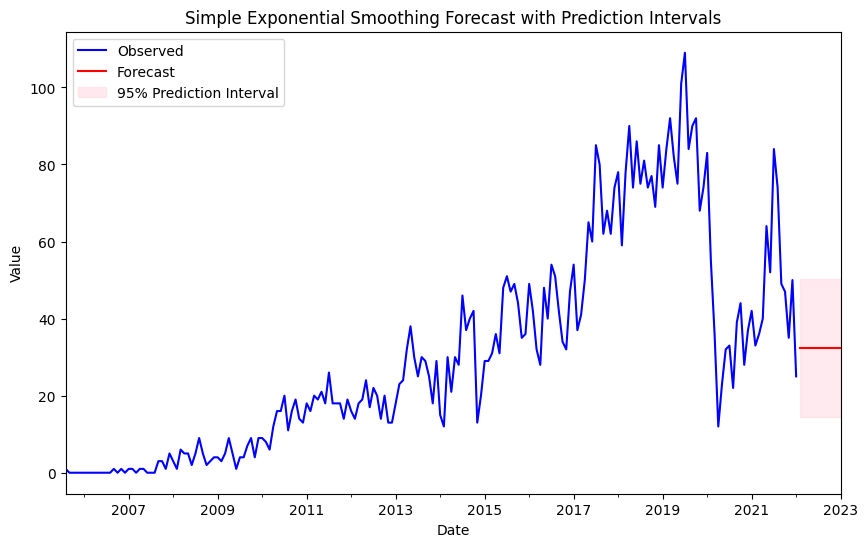

In [51]:
# Plot future forecast for the best model with probability intervals

# Model Holt Linear Damped
variable = 'count'

exam_data = neutral_reviews_per_month.copy()[variable]
exam_data = exam_data.dropna()
train = exam_data

# Fit the SimpleExponentialSmoothing model
model = SimpleExpSmoothing(train)
results = model.fit()

# Generate forecasts for the next 12 months
forecast_periods = 12
forecast = results.forecast(forecast_periods)

# Calculate prediction intervals
alpha = 0.05
z = 1.96  # Z-score for 95% confidence interval

# Calculate standard error of forecast
residuals = train - results.fittedvalues
stderr = residuals.std()

# Generate confidence intervals
forecast_index = pd.date_range(start=train.index[-1], periods=forecast_periods+1, freq='M')[1:]
conf_int = z * stderr

# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))
train.plot(ax=ax, label='Observed', color='blue')
forecast.plot(ax=ax, label='Forecast', color='red')

# Plot confidence intervals
ax.fill_between(forecast_index, forecast - conf_int, forecast + conf_int, color='pink', alpha=0.3, label='95% Prediction Interval')

# Add labels and legend
ax.set_title('Simple Exponential Smoothing Forecast with Prediction Intervals')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.legend(loc='upper left')

# Show the plot
plt.show()

c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive par

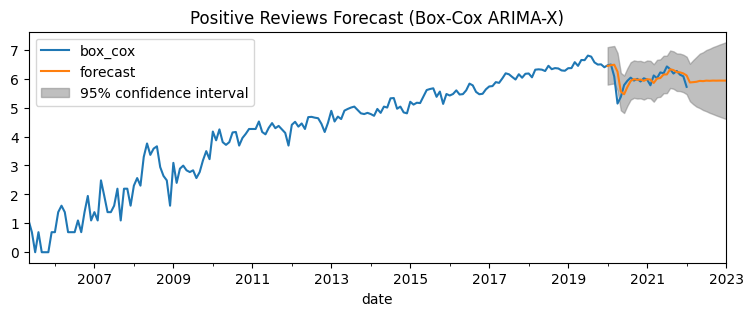

In [54]:
# plot future forecast for the best model with probability intervals

# Model ARIMA
variable = 'count'

exam_data = positive_reviews_per_month.copy()['box_cox']
exam_data = exam_data.dropna()
train = exam_data

# predictions for the next 12 months
model = ARIMA(train, order=(4,1,2))
results = model.fit()
fig, ax = plt.subplots(figsize=(9, 3))
ax = train.plot(ax=ax)
plot_predict(results, '2020', '2023', ax=ax)
plt.title('Positive Reviews Forecast (Box-Cox ARIMA-X)')
plt.show()

#### Sentiment

In [29]:
# box-cox model info

print(sentiment_box_cox_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                box_cox   No. Observations:                  201
Model:                 ARIMA(4, 1, 2)   Log Likelihood                 178.515
Date:                Mon, 20 May 2024   AIC                           -343.031
Time:                        17:54:23   BIC                           -319.943
Sample:                    05-31-2005   HQIC                          -333.687
                         - 01-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3294      0.080     16.626      0.000       1.173       1.486
ar.L2         -0.4802      0.103     -4.676      0.000      -0.681      -0.279
ar.L3          0.0823      0.085      0.967      0.3

In [30]:
# model info

print(sentiment_arima.summary()) 

                               SARIMAX Results                                
Dep. Variable:              sentiment   No. Observations:                  201
Model:                 ARIMA(1, 1, 4)   Log Likelihood                 124.496
Date:                Mon, 20 May 2024   AIC                           -236.992
Time:                        17:54:41   BIC                           -217.202
Sample:                    05-31-2005   HQIC                          -228.983
                         - 01-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8801      0.073     12.029      0.000       0.737       1.024
ma.L1         -1.4805      0.102    -14.581      0.000      -1.679      -1.281
ma.L2          0.2013      0.129      1.555      0.1

C:\Users\Utilizador\AppData\Local\Temp\ipykernel_14340\4044320444.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_m

Best model: holt_linear_damped_sentiment
MSE: 0.01818455431733088


c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model       MAE       MSE      RMSE       MAPE  \
0       baseline_mean_sentiment  0.142420  0.032713  0.180868  38.464680   
1     baseline_median_sentiment  0.119153  0.031484  0.177436  32.164055   
2      baseline_naive_sentiment  0.100776  0.023136  0.152106  23.471432   
3                 ses_sentiment  0.086586  0.018289  0.135237  21.084688   
4  holt_linear_damped_sentiment  0.095863  0.018185  0.134850  22.695224   
5       box_cox_arima_sentiment  0.933607  0.889273  0.943013  65.544859   
6               arima_sentiment  0.089961  0.019403  0.139296  22.029581   

       MASE  
0  1.420883  
1  1.188758  
2  1.005414  
3  0.863839  
4  0.956398  
5  9.314324  
6  0.897517

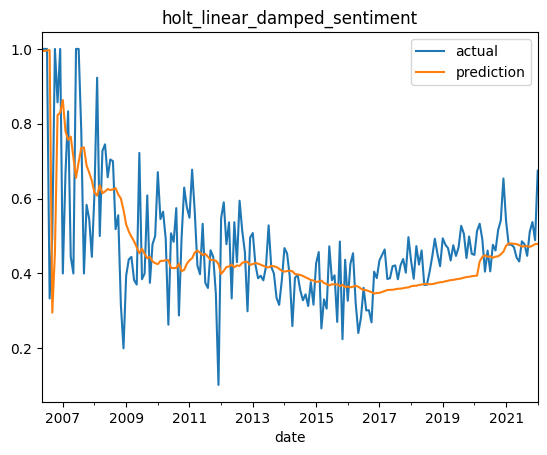

In [31]:
def box_cox_temp(x):
    time_series_for_arima = sentiment_per_month['box_cox'].reindex(x.index)
    return ARIMA(time_series_for_arima, order=(4, 1, 2)).fit().forecast(1).iloc[0]

def temp(x):
    time_series_for_arima = sentiment_per_month['sentiment'].reindex(x.index)
    return ARIMA(time_series_for_arima, order=(1, 1, 4)).fit().forecast(1).iloc[0]

evaluate_and_plot_best(
    sentiment_per_month, 
    lambda_sentiment, 
    shift_sentiment,
    comparison='MSE', 
    extra_models={'box_cox_arima': box_cox_temp, 'arima': temp}, 
    extra_variables=['sentiment']
)

c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive par

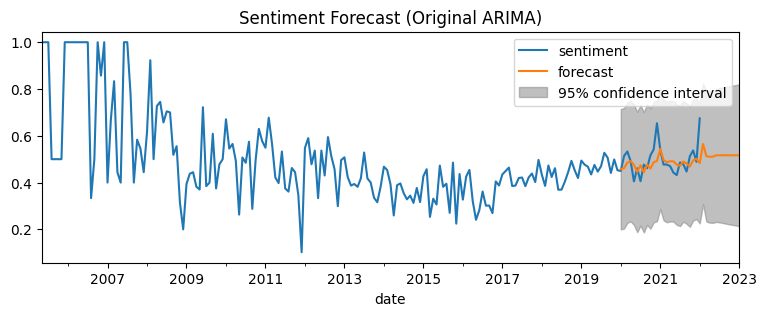

In [56]:
# plot future forecast for the best model with probability intervals

# Model ARIMA
variable = 'sentiment'

exam_data = sentiment_per_month.copy()[variable]
exam_data = exam_data.dropna()
train = exam_data

# predictions for the next 12 months
model = ARIMA(train, order=(4,1,2))
results = model.fit()
fig, ax = plt.subplots(figsize=(9, 3))
ax = train.plot(ax=ax)
plot_predict(results, '2020', '2023', ax=ax)
plt.title('Sentiment Forecast (Original ARIMA)')
plt.show()

#### Restaurant sentiment

In [32]:
# box-cox model info

print(restaurant_box_cox_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                box_cox   No. Observations:                  201
Model:                 ARIMA(3, 1, 4)   Log Likelihood                 -12.614
Date:                Mon, 20 May 2024   AIC                             41.229
Time:                        17:59:45   BIC                             67.616
Sample:                    05-31-2005   HQIC                            51.907
                         - 01-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2505      0.131      1.914      0.056      -0.006       0.507
ar.L2         -0.2795      0.147     -1.906      0.057      -0.567       0.008
ar.L3         -0.2808      0.092     -3.063      0.0

In [33]:
# model info

print(restaurant_arima.summary())

                               SARIMAX Results                                
Dep. Variable:              sentiment   No. Observations:                  201
Model:                 ARIMA(2, 1, 4)   Log Likelihood                  76.704
Date:                Mon, 20 May 2024   AIC                           -139.408
Time:                        18:00:00   BIC                           -116.319
Sample:                    05-31-2005   HQIC                          -130.064
                         - 01-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5521      0.075      7.315      0.000       0.404       0.700
ar.L2         -0.5952      0.102     -5.837      0.000      -0.795      -0.395
ma.L1         -0.9682      0.084    -11.519      0.0

C:\Users\Utilizador\AppData\Local\Temp\ipykernel_14340\3372731274.py:6: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_14340\4044320444.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_14340\3372731274.py:6: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_14340\3372731274.py:6: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
c:\Users\Utilizador\AppData\Local\

Best model: ses_sentiment
MSE: 0.02756398991993049


c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_14340\3372731274.py:6: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


Model       MAE       MSE      RMSE        MAPE  \
0       baseline_mean_sentiment  0.116348  0.029741  0.172457         inf   
1     baseline_median_sentiment  0.121837  0.041311  0.203252         inf   
2      baseline_naive_sentiment  0.115100  0.031457  0.177362         inf   
3                 ses_sentiment  0.104665  0.027564  0.166024         inf   
4  holt_linear_damped_sentiment  0.104941  0.028213  0.167968         inf   
5       box_cox_arima_sentiment  1.070050  1.170404  1.081852  221.230055   
6               arima_sentiment  0.116066  0.029191  0.170853         inf   

       MASE  
0  0.979610  
1  1.025826  
2  0.969104  
3  0.881242  
4  0.883573  
5  9.009463  
6  0.977237

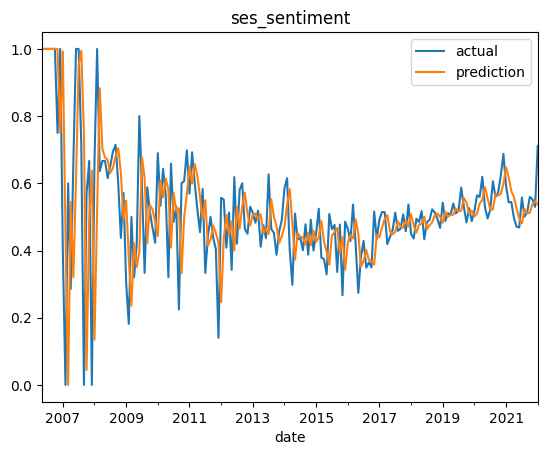

In [34]:
def box_cox_temp(x):
    time_series_for_arima = sentiment_restaurants_per_month['box_cox'].reindex(x.index)
    return ARIMA(time_series_for_arima, order=(3, 1, 4)).fit().forecast(1).iloc[0]

def temp(x):
    time_series_for_arima = sentiment_restaurants_per_month['sentiment'].reindex(x.index)
    return ARIMA(time_series_for_arima, order=(2, 1, 4)).fit().forecast(1).iloc[0]

evaluate_and_plot_best(
    sentiment_restaurants_per_month, 
    lambda_restaurants, 
    shift_restaurants,
    comparison='MSE', 
    extra_models={'box_cox_arima': box_cox_temp, 'arima': temp},
    extra_variables=['sentiment']
)

c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_14340\1221770109.py:27: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=train.index[-1], periods=forecast_periods+1, freq='M')[1:]


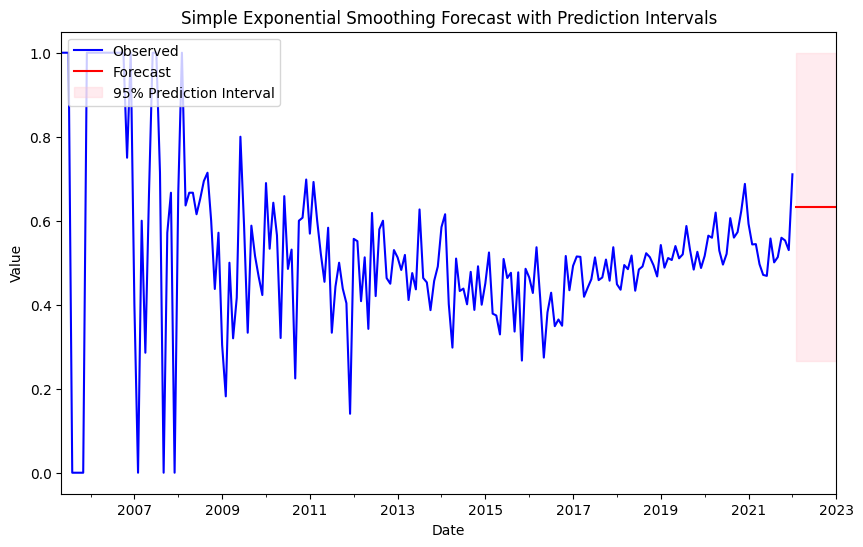

In [55]:
# Plot future forecast for the best model with probability intervals

# Model Holt Linear Damped
variable = 'sentiment'

exam_data = sentiment_restaurants_per_month.copy()[variable]
exam_data = exam_data.dropna()
train = exam_data

# Fit the SimpleExponentialSmoothing model
model = SimpleExpSmoothing(train)
results = model.fit()

# Generate forecasts for the next 12 months
forecast_periods = 12
forecast = results.forecast(forecast_periods)

# Calculate prediction intervals
alpha = 0.05
z = 1.96  # Z-score for 95% confidence interval

# Calculate standard error of forecast
residuals = train - results.fittedvalues
stderr = residuals.std()

# Generate confidence intervals
forecast_index = pd.date_range(start=train.index[-1], periods=forecast_periods+1, freq='M')[1:]
conf_int = z * stderr

# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))
train.plot(ax=ax, label='Observed', color='blue')
forecast.plot(ax=ax, label='Forecast', color='red')

# Plot confidence intervals
ax.fill_between(forecast_index, forecast - conf_int, forecast + conf_int, color='pink', alpha=0.3, label='95% Prediction Interval')

# Add labels and legend
ax.set_title('Simple Exponential Smoothing Forecast with Prediction Intervals')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.legend(loc='upper left')

# Show the plot
plt.show()

#### Nightlife sentiment

In [35]:
# box-cox model info

print(nightlife_box_cox_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                box_cox   No. Observations:                  201
Model:                 ARIMA(1, 1, 3)   Log Likelihood                 -99.321
Date:                Mon, 20 May 2024   AIC                            208.642
Time:                        18:06:38   BIC                            225.134
Sample:                    05-31-2005   HQIC                           215.316
                         - 01-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3115      0.118     -2.640      0.008      -0.543      -0.080
ma.L1         -0.2245     61.231     -0.004      0.997    -120.235     119.785
ma.L2         -0.3401     47.460     -0.007      0.9

In [36]:
# model info

print(nightlife_arima.summary())

                               SARIMAX Results                                
Dep. Variable:              sentiment   No. Observations:                  201
Model:                 ARIMA(0, 1, 4)   Log Likelihood                 -16.516
Date:                Mon, 20 May 2024   AIC                             43.032
Time:                        18:06:43   BIC                             59.523
Sample:                    05-31-2005   HQIC                            49.706
                         - 01-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5151     55.607     -0.009      0.993    -109.502     108.472
ma.L2         -0.1884     26.964     -0.007      0.994     -53.037      52.660
ma.L3         -0.4132     16.493     -0.025      0.9

C:\Users\Utilizador\AppData\Local\Temp\ipykernel_14340\3372731274.py:6: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_14340\4044320444.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_14340\3372731274.py:6: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_14340\3372731274.py:6: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
c:\Users\Utilizador\AppData\Local\

Best model: baseline_mean_sentiment
MSE: 0.08483287188005133


C:\Users\Utilizador\AppData\Local\Temp\ipykernel_14340\3372731274.py:6: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


Model       MAE       MSE      RMSE        MAPE  \
0       baseline_mean_sentiment  0.172264  0.084833  0.291261         inf   
1     baseline_median_sentiment  0.183289  0.127028  0.356410         inf   
2      baseline_naive_sentiment  0.168036  0.096202  0.310165         inf   
3                 ses_sentiment  0.152887  0.087525  0.295846         inf   
4  holt_linear_damped_sentiment  0.155170  0.089076  0.298456         inf   
5       box_cox_arima_sentiment  1.064408  1.173812  1.083426  241.731721   
6               arima_sentiment  0.156004  0.087980  0.296614         inf   

       MASE  
0  1.020555  
1  1.085874  
2  0.995509  
3  0.905759  
4  0.919283  
5  6.305943  
6  0.924224

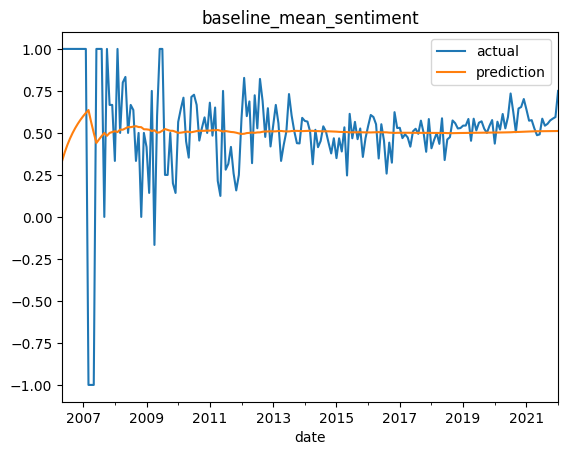

In [37]:
def box_cox_temp(x):
    time_series_for_arima = sentiment_nightlife_per_month['box_cox'].reindex(x.index)
    return ARIMA(time_series_for_arima, order=(1, 1, 3)).fit().forecast(1).iloc[0]

def temp(x):
    time_series_for_arima = sentiment_nightlife_per_month['sentiment'].reindex(x.index)
    return ARIMA(time_series_for_arima, order=(1, 1, 4)).fit().forecast(1).iloc[0]

evaluate_and_plot_best(
    sentiment_nightlife_per_month, 
    lambda_nightlife, 
    shift_nightlife,
    comparison='MSE', 
    extra_models={'box_cox_arima': box_cox_temp, 'arima': temp},
    extra_variables=['sentiment']
)

In [ ]:
# Plot future forecast for the best model with probability intervals

# Model ARIMA
variable = 'trend'

exam_data = sentiment_nightlife_per_month.copy()[variable]
exam_data = exam_data.dropna()
train = exam_data

# predictions for the next 12 months
model = ARIMA(train, order=(2,0,2))
results = model.fit()
fig, ax = plt.subplots()
ax = train.plot(ax=ax)
plot_predict(results, '2020', '2023', ax=ax)
plt.show()

#### Breakfast & brunch sentiment

In [38]:
# box-cox model info

print(breakfast_brunch_box_cox_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                box_cox   No. Observations:                  191
Model:                 ARIMA(3, 1, 3)   Log Likelihood                 -50.434
Date:                Mon, 20 May 2024   AIC                            114.868
Time:                        18:13:27   BIC                            137.597
Sample:                    03-31-2006   HQIC                           124.076
                         - 01-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6210      0.080     20.380      0.000       1.465       1.777
ar.L2         -1.3336      0.093    -14.375      0.000      -1.515      -1.152
ar.L3          0.3536      0.079      4.480      0.0

In [39]:
# model info

print(breakfast_brunch_arima.summary())

                               SARIMAX Results                                
Dep. Variable:              sentiment   No. Observations:                  191
Model:                 ARIMA(3, 1, 3)   Log Likelihood                  34.204
Date:                Mon, 20 May 2024   AIC                            -54.407
Time:                        18:13:33   BIC                            -31.678
Sample:                    03-31-2006   HQIC                           -45.200
                         - 01-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6163      0.067     24.083      0.000       1.485       1.748
ar.L2         -1.3272      0.085    -15.703      0.000      -1.493      -1.162
ar.L3          0.3718      0.067      5.508      0.0

C:\Users\Utilizador\AppData\Local\Temp\ipykernel_14340\3372731274.py:6: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_14340\4044320444.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_14340\3372731274.py:6: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_14340\3372731274.py:6: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
C:\Users\Utilizador\AppData\Local\

Best model: ses_sentiment
MSE: 0.056530937848469874


c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_14340\3372731274.py:6: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


Model       MAE       MSE      RMSE        MAPE  \
0       baseline_mean_sentiment  0.176361  0.063737  0.252461         inf   
1     baseline_median_sentiment  0.196726  0.089120  0.298529         inf   
2      baseline_naive_sentiment  0.177765  0.067870  0.260519         NaN   
3                 ses_sentiment  0.164097  0.056531  0.237762         inf   
4  holt_linear_damped_sentiment  0.171555  0.059503  0.243933         inf   
5       box_cox_arima_sentiment  1.062350  1.181530  1.086982  205.693339   
6               arima_sentiment  0.170253  0.058516  0.241902         inf   

       MASE  
0  1.053070  
1  1.174672  
2  1.061453  
3  0.979843  
4  1.024372  
5  6.343411  
6  1.016601

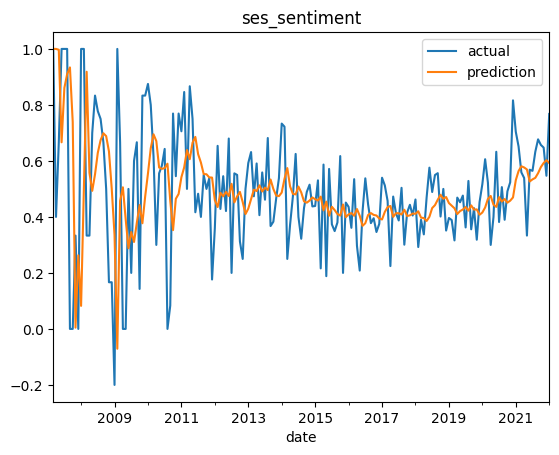

In [41]:
def box_cox_temp(x):
    time_series_for_arima = sentiment_breakfast_brunch_per_month['box_cox'].reindex(x.index)
    return ARIMA(time_series_for_arima, order=(3, 1, 3)).fit().forecast(1).iloc[0]

def temp(x):
    time_series_for_arima = sentiment_breakfast_brunch_per_month['sentiment'].reindex(x.index)
    return ARIMA(time_series_for_arima, order=(3, 1, 4)).fit().forecast(1).iloc[0]

evaluate_and_plot_best(
    sentiment_breakfast_brunch_per_month, 
    lambda_breakfast_brunch, 
    shift_breakfast_brunch,
    comparison='MSE', 
    extra_models={'box_cox_arima': box_cox_temp, 'arima': temp},
    extra_variables=['sentiment']
)

In [ ]:
# Plot future forecast for the best model with probability intervals

# Model ARIMA
variable = 'sentiment'

exam_data = sentiment_breakfast_brunch_per_month.copy()[variable]
exam_data = exam_data.dropna()
train = exam_data

# predictions for the next 12 months
model = ARIMA(train, order=(4,0,3))
results = model.fit()
fig, ax = plt.subplots()
ax = train.plot(ax=ax)
plot_predict(results, '2020', '2023', ax=ax)
plt.show()